<a href="https://colab.research.google.com/github/MiKatre/recommendations-api/blob/notebook-1/p6_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'cinetimes/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Fetch data

###### Set env

In [0]:
#import os
#os.environ['SQLALCHEMY_DATABASE_URL'] = ""

###### Movie lens 20M



In [0]:
import urllib.request
import zipfile

url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
path = Path(base_dir + 'data/')

path.mkdir(parents=True, exist_ok=True)
dest_zip = path/'ml-20m.zip'
dest_unzip = path/'ml-20m'

if not dest_unzip.exists():
  print('Downloading and extracting files...')
  urllib.request.urlretrieve(url, dest_zip)

  with zipfile.ZipFile(dest_zip, 'r') as ref:
    ref.extractall(path)

  print('Removing zip file...')
  dest_zip.unlink()
  print('Done !')

else:
  print('Files already downloaded...')

path = dest_unzip

Files already downloaded...


###### Database

In [0]:
# !pip install mysqlclient
# from sqlalchemy import create_engine
# from sqlalchemy.ext.declarative import declarative_base
# from sqlalchemy.orm import sessionmaker

In [0]:
# SQLALCHEMY_DATABASE_URL=os.environ.get('SQLALCHEMY_DATABASE_URL')
# engine = create_engine(SQLALCHEMY_DATABASE_URL)
# Session = sessionmaker(autocommit=False, autoflush=False, bind=engine)
# session = Session()

## Train the model

In [0]:
ratings = pd.read_csv(base_dir + 'cinetimes-dataset.csv')

Join the movie names according the imdbId in the dataset


In [0]:
# def add_tt(movie_id):
#     return f"tt{movie_id}"

# external_ids = pd.read_csv(base_dir + 'data/ml-20m/links.csv', converters={'imdbId': str, 'tmdbId': str})
# movies = pd.read_csv(base_dir + 'data/ml-20m/movies.csv')
# external_ids['imdbId'] = external_ids['imdbId'].apply(add_tt)

# external_ids = external_ids.merge(movies, left_on='movieId', right_on='movieId')
# ratings = ratings.merge(external_ids, left_on='imdbId', right_on='imdbId')

In [0]:
ratings.head()

,imdbId,rating,userId
0,tt0113497,3.5,9999991
1,tt0113497,3.0,9999995
2,tt0113497,3.0,99999913
3,tt0113497,3.0,99999929
4,tt0113497,3.0,99999934


In [0]:
# Change column order to fit CollabDataBunch
ratings = ratings[['userId', 'imdbId','rating']]
ratings.head()

,userId,imdbId,rating
0,9999991,tt0113497,3.5
1,9999995,tt0113497,3.0
2,99999913,tt0113497,3.0
3,99999929,tt0113497,3.0
4,99999934,tt0113497,3.0


In [0]:
# Comment if you want the full dataset
#smaller_ratings = ratings[10000000:]
# smaller_ratings = ratings[-5000000:] # Last 5M
# ratings = smaller_ratings
# ratings.tail()

In [0]:
len(ratings)

5000039

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, bs=128)

In [0]:
data.show_batch()

userId,imdbId,target
99999918389,tt0047472,1.0
99999910339,tt1035736,3.5
9999993514,tt0145681,3.5
99999918780,tt0120770,0.5
99999924990,tt0117589,4.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


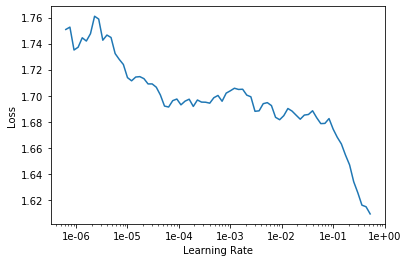

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.837365,0.833849,08:20
1,0.830803,0.838225,08:35
2,0.770846,0.807977,08:38
3,0.735024,0.754556,08:27
4,0.767562,0.730516,08:22


In [0]:
learn.save('prodmodel-2')

In [0]:
learn.save(base_dir + '/prodmodel-2')

In [0]:
# Export for production
learn.export(base_dir + '/prodmodel-2')

In [0]:
#learn.load(base_dir + '/prodmodel-2')
#learn = load_learner(base_dir, 'prodmodel.pth')

In [0]:
# Only keep my users
all_users = ratings.loc[ratings['userId'] < 999999]

# Get array of users id
my_users = all_users['userId'].unique()

# Get array of all movies id
all_movie_ids = ratings['imdbId'].unique()

data = []
for user_id in my_users:
  # Get list of all movies rated by the userId
  user_rated_rows = ratings.loc[ratings['userId'] == user_id]
  user_rated_ids = user_rated_rows['imdbId'].unique()
  
  # Remove the movie_ids that user_x has rated from the list of all movie ids
  movie_ids_to_pred = np.setdiff1d(all_movie_ids, user_rated_ids)
  
  # Create a dataframe with movies not rated by user
  
  for movie_id in movie_ids_to_pred:
    data.append({
        'userId': user_id,
        'imdbId': movie_id,
        'rating': None,
    })
  
df_to_predict = pd.DataFrame(data=data)

print(df_to_predict.head())


   userId     imdbId rating
0    1162  tt0000005   None
1    1162  tt0000010   None
2    1162  tt0000012   None
3    1162  tt0000014   None
4    1162  tt0000417   None


In [0]:
my_users

array([1162, 1283, 1161, 1406, 1405])

In [0]:
# Predict
predictions = []
for idx in range(len(df_to_predict)):
  row = df_to_predict.iloc[idx]
  movie_id = row['imdbId']
  user_id = row['userId']
  y, pred, raw_pred = learn.predict(row)
  prediction = {'userId': user_id, 'movie_id': movie_id, 'prediction': pred.item()}
  predictions.append(prediction)
  if pred.item() > 4.0: 
    print(movie_id, pred.item())

tt0068646 4.064924240112305
tt0102926 4.070297718048096
tt0111161 4.37367057800293
tt0114814 4.1719818115234375
tt0111161 4.012946128845215
tt0111161 4.081221580505371
tt0111161 4.0153093338012695


In [0]:
# Sort predictions
full_predictions = pd.DataFrame(predictions)
sorted_predictions = full_predictions.sort_values(by='prediction', ascending=False)

In [0]:
sorted_predictions

,userId,movie_id,prediction
8363,1162,tt0111161,4.373671
8822,1162,tt0114814,4.171982
49154,1161,tt0111161,4.081222
7428,1162,tt0102926,4.070298
3831,1162,tt0068646,4.064924
...,...,...,...
9676,1162,tt0120185,2.212290
31196,1283,tt0185183,2.208998
9325,1162,tt0118665,2.188134
92401,1405,tt0185183,2.144603


Store predictions

In [0]:
# TO ERASE. Uncomment if you lost your mind or you know what you are doing (load my previous predictions)
# sorted_predictions = pd.read_csv(root_dir + '/predictions.csv')

In [0]:
sorted_filtered_predictions = sorted_predictions[0:0]
for user_id in my_users:
  this_user_df = sorted_predictions.loc[sorted_predictions['userId'] == user_id]
  # Limit to the 500 first recommendations
  this_user_df = this_user_df[0:500]
  sorted_filtered_predictions = sorted_filtered_predictions.append(this_user_df)

In [0]:
len(sorted_filtered_predictions)

2500

In [0]:
sorted_filtered_predictions.to_csv(index=False, path_or_buf=root_dir + '/predictions.csv')

## Interprétation

In [0]:
g = ratings.groupby('imdbId')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]
learn.get_idx(arr=top_movies, is_item=True)

tensor([ 8202,  8051,  8235,  7303,  7767,  4450,  8354,  7320,  9970,  7856,
         8680,  7723,  8322,  5409,  8913,  8694,  6595,  4785, 10480,  8686,
         5072,  8844,  6887,  8271,  8636,  5670,  8248,  7354,  3743, 10018,
        10449,  8124,  7945,  9709,  9751,  8992,  9419,  7110,  8146,  5638,
        10448,  8407,  7806,  7017, 10514,  4047,  6260,  8337,  5157,  9577,
         9119,  8328,  8028,  9880,  7730,  8251,  6686, 10447,  9049,  4594,
         6401,  5135, 10920,  4171,  9797,  5547,  6922,  8459,  7998,  7868,
         9326,  3693,  6947,  8052,  9303,  5866,  8096,  7541,  8703,  4013,
         9644,  9791,  9378,  6927,  8378,  8250,  8590,  8137, 12508,  7716,
         3182, 10715,  3589,  7681,  8573,  4325,  9587, 10020,  6508, 10165,
         9932, 10956,   968,  8476,  9110, 11626,  8454, 10159, 11252, 10793,
        10612,  8170,  8386,  2641,   826,  4884,  7999, 10370,  8706,  4600,
         5918,  9636,  9581, 12667,  8755,  8926,  8768,  8507, 

### Movie bias

In [0]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = ratings.groupby('imdbId')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [0]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3271), 'tt0120179', 1.8675918979744937),
 (tensor(-0.2785), 'tt0108255', 2.0309888579387185),
 (tensor(-0.2384), 'tt0118615', 2.0959774170783345),
 (tensor(-0.1942), 'tt0118688', 2.1801339285714287),
 (tensor(-0.1860), 'tt0120891', 2.320194384449244),
 (tensor(-0.1821), 'tt0110989', 2.39177657098526),
 (tensor(-0.1778), 'tt0114436', 2.2511061946902653),
 (tensor(-0.1651), 'tt0109813', 2.4488286066584464),
 (tensor(-0.1608), 'tt0120685', 2.2878048780487803),
 (tensor(-0.1584), 'tt0117765', 2.416131792896876),
 (tensor(-0.1553), 'tt0112281', 2.6078507578701906),
 (tensor(-0.1448), 'tt0242423', 2.4435674822415154),
 (tensor(-0.1400), 'tt0134084', 2.455784574468085),
 (tensor(-0.1356), 'tt0106598', 2.582474226804124),
 (tensor(-0.1298), 'tt0120738', 2.5448038176033934)]

In [0]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.9740), 'tt0111161', 4.450886075949367),
 (tensor(0.8071), 'tt0108052', 4.307224122841912),
 (tensor(0.8068), 'tt0114814', 4.347230519757617),
 (tensor(0.7556), 'tt0102926', 4.180525373897482),
 (tensor(0.7081), 'tt0068646', 4.347281553398059),
 (tensor(0.6880), 'tt0076759', 4.192349886637899),
 (tensor(0.6812), 'tt0106977', 3.97530262409619),
 (tensor(0.6743), 'tt0109830', 4.0296094459582195),
 (tensor(0.6675), 'tt0110912', 4.16751481769742),
 (tensor(0.6671), 'tt0112573', 4.042618530447157),
 (tensor(0.6562), 'tt0082971', 4.21310420878515),
 (tensor(0.6410), 'tt0133093', 4.177908151371513),
 (tensor(0.6124), 'tt0093779', 4.177039941190885),
 (tensor(0.6027), 'tt0073486', 4.255806148476306),
 (tensor(0.5967), 'tt0114369', 4.059125723893144)]

### Movie weights

In [0]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [0]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.6897), 'tt0116629'),
 (tensor(1.6229), 'tt0113957'),
 (tensor(1.5396), 'tt0112715'),
 (tensor(1.5339), 'tt0117998'),
 (tensor(1.5168), 'tt0120591'),
 (tensor(1.5067), 'tt0116213'),
 (tensor(1.5042), 'tt0114781'),
 (tensor(1.4992), 'tt0113071'),
 (tensor(1.4823), 'tt0120179'),
 (tensor(1.4789), 'tt0120891')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.6507), 'tt0057012'),
 (tensor(-1.5099), 'tt0066921'),
 (tensor(-1.4900), 'tt0033467'),
 (tensor(-1.4664), 'tt0075686'),
 (tensor(-1.4633), 'tt0041959'),
 (tensor(-1.4522), 'tt0071315'),
 (tensor(-1.4105), 'tt0047478'),
 (tensor(-1.3801), 'tt0078788'),
 (tensor(-1.3744), 'tt0081398'),
 (tensor(-1.3258), 'tt0043014')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.5358), 'tt0137523'),
 (tensor(1.0802), 'tt0110912'),
 (tensor(1.0799), 'tt0401792'),
 (tensor(0.9999), 'tt0120669'),
 (tensor(0.9816), 'tt0133093'),
 (tensor(0.9740), 'tt0208092'),
 (tensor(0.9073), 'tt0110632'),
 (tensor(0.8860), 'tt0119081'),
 (tensor(0.8842), 'tt0120735'),
 (tensor(0.8838), 'tt0468569')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.5668), 'tt0112431'),
 (tensor(-1.4609), 'tt0101414'),
 (tensor(-1.3161), 'tt0029583'),
 (tensor(-1.2636), 'tt0032138'),
 (tensor(-1.2617), 'tt0059742'),
 (tensor(-1.2471), 'tt0108160'),
 (tensor(-1.1695), 'tt0114388'),
 (tensor(-1.1450), 'tt0056592'),
 (tensor(-1.0990), 'tt0138097'),
 (tensor(-1.0873), 'tt0058331')]

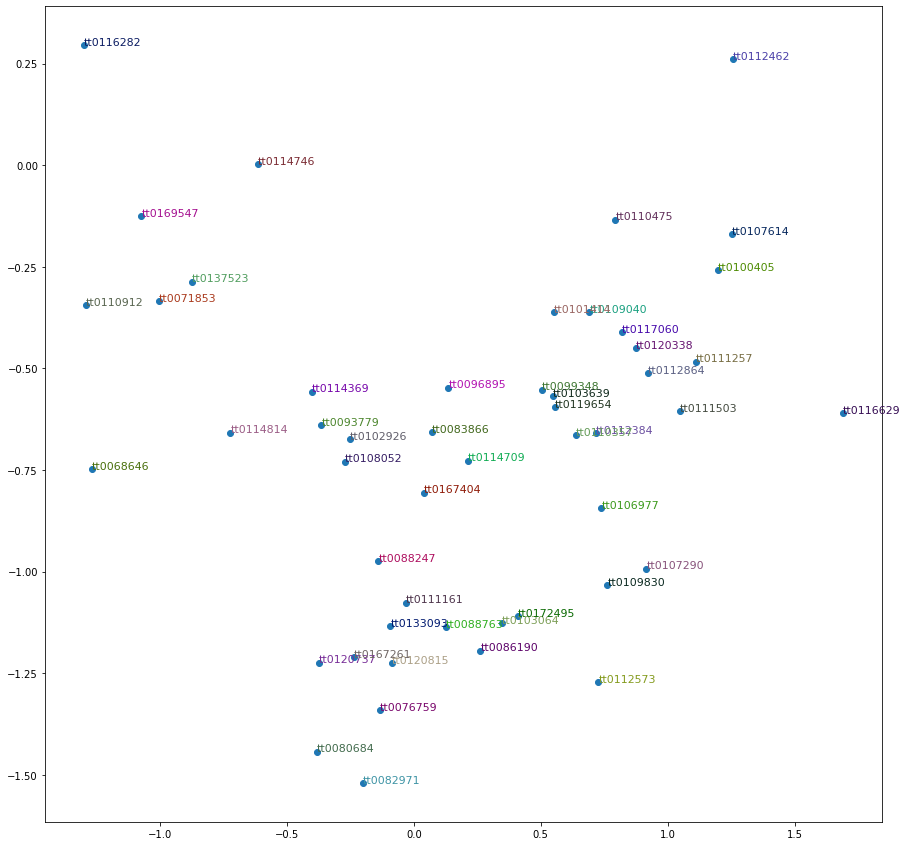

In [0]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()